# Data Visualization

This notebook is meant to visualize and explore our dataset. It features some helper functions to load the annotations and display them. We also try to check for class imbalance.

In a production environment, use dedicated libraries or tools like Voxel51 to get more functionalities.

In [2]:
from __future__ import annotations

import os
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Dict, List, Tuple, Union

import cv2
import matplotlib.pyplot as plt

Our dataset is located in the **data/** folder.

In [3]:
dataset_path = Path("data")

Load all the filenames in Python dicts.

In [4]:
def get_filenames_fromdir(
    filepath: Union[str, os.PathLike], folder: str
) -> Tuple[Dict[int, str], Dict[int, str]]:
    files = os.listdir(filepath / folder)
    filename_images = dict()
    filename_labels = dict()
    index = 1

    for f in files:
        if f.endswith(".jpg"):
            filename_images[index] = f
        else:
            filename_labels[index] = f
            index += 1

    print(folder, " : ", index - 1, "images")
    return filename_images, filename_labels

In [5]:
train_filename_images = dict()
train_filename_labels = dict()
train_filename_images, train_filename_labels = get_filenames_fromdir(
    dataset_path, "train"
)

valid_filename_images = dict()
valid_filename_labels = dict()
valid_filename_images, valid_filename_labels = get_filenames_fromdir(
    dataset_path, "valid"
)

test_filename_images = dict()
test_filename_labels = dict()
test_filename_images, test_filename_labels = get_filenames_fromdir(dataset_path, "test")

train  :  105 images
valid  :  29 images
test  :  15 images


Display an image:

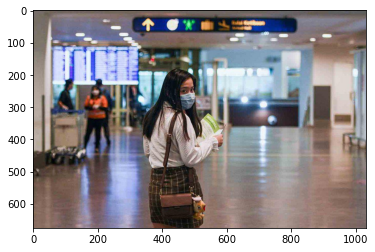

In [6]:
bgr_img = cv2.imread(str(dataset_path / "train" / train_filename_images[3]))
rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_img)
plt.show()

All the annotations are stored in XML files. We'll write a function to load them in Python.

In [7]:
def extract_boxes(
    filename_xml: Union[str, os.PathLike]
) -> Tuple[List[List[int]], List[List[int]], int, int]:
    """
    Extract bounding boxes and image dimensions from an XML file.

    Parameters
    ----------
    filename_xml : str or os.PathLike
        The path to the XML file.

    Returns
    -------
    boxes_mask : List[List[int]]
        A list of bounding boxes for objects with the "mask" label.
    boxes_nomask : List[List[int]]
        A list of bounding boxes for objects with the "nomask" label.
    width : int
        The width of the image.
    height : int
        The height of the image.
    """
    # load and parse the file
    tree = ET.parse(filename_xml)

    # get the root of the document
    root = tree.getroot()

    # extract each bounding box
    boxes_nomask = list()
    boxes_mask = list()
    for box in root.findall(".//object"):
        xmin = int(box.find("bndbox/xmin").text)
        ymin = int(box.find("bndbox/ymin").text)
        xmax = int(box.find("bndbox/xmax").text)
        ymax = int(box.find("bndbox/ymax").text)
        coors = [xmin, ymin, xmax, ymax]

        if str(box.find("name").text) == "mask":
            boxes_mask.append(coors)
        else:
            boxes_nomask.append(coors)

    # extract image dimensions
    width = int(root.find(".//size/width").text)
    height = int(root.find(".//size/height").text)
    return boxes_mask, boxes_nomask, width, height

Let's try our function on a XML file:

In [8]:
# extract details from a single annotation file
boxes_mask, boxes_nomask, w, h = extract_boxes(
    dataset_path / "train" / train_filename_labels[5]
)

# summarize extracted details
print("Bounding box with masks (Xmin, Ymin, Xmax, Ymax) :", boxes_mask)
print("Bounding box w/ masks:", boxes_nomask)
print("Width: ", w, "Height: ", h)

Bounding box with masks (Xmin, Ymin, Xmax, Ymax) : [[467, 59, 693, 277]]
Bounding box w/ masks: []
Width:  1240 Height:  698


After getting our annotations, we would like to display them on the corresponding images.

In [9]:
def display_images_withlabels(filename_img: Union[str, os.PathLike]) -> None:
    img = cv2.imread(str(filename_img))
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert str ending from jpg to xml
    boxes_mask, boxes_nomask, __, __ = extract_boxes(filename_img.with_suffix(".xml"))

    for Xmin, Ymin, Xmax, Ymax in boxes_mask:
        cv2.rectangle(rgb_img, (Xmin, Ymin), (Xmax, Ymax), (0, 255, 0), 4)  # Green

    for Xmin, Ymin, Xmax, Ymax in boxes_nomask:
        cv2.rectangle(rgb_img, (Xmin, Ymin), (Xmax, Ymax), (255, 0, 0), 4)  # Red

    plt.imshow(rgb_img)
    plt.show()

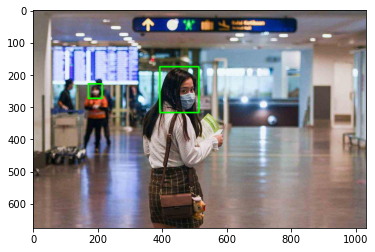

In [10]:
display_images_withlabels(dataset_path / "train" / train_filename_images[3])

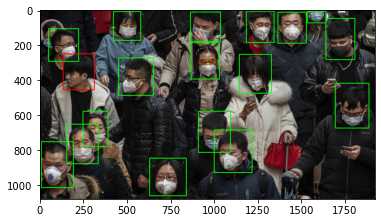

In [11]:
display_images_withlabels(dataset_path / "train" / train_filename_images[10])

Finally, we would like to get some basic information about our dataset:
- Minimum / Maximum / Average Height
- Minimum / Maximum / Average Width
- Minimum / Maximum / Average number of masks per picture
- Minimum / Maximum / Average number of no-masks per picture

In [12]:
str_to_variable = {
    "train": train_filename_images,
    "valid": valid_filename_images,
    "test": test_filename_images,
}

for folder in ["train", "valid", "test"]:
    width_list = []
    height_list = []
    labels_list = []

    for x in range(1, len(str_to_variable[folder]) + 1):
        xml_filename = str_to_variable[folder][x].replace(".jpg", ".xml")
        boxes_mask, boxes_nomask, w, h = extract_boxes(
            str(dataset_path / folder / xml_filename)
        )
        width_list += [w]
        height_list += [h]
        labels_list += [(len(boxes_mask), len(boxes_nomask))]

    print("\n" + folder + ":")
    print("Min and Max Width :", min(width_list), "-", max(width_list))
    print("Average Width :", sum(width_list) / len(width_list))
    print("Min and Max Height :", min(height_list), "-", max(height_list))
    print("Average Height :", sum(height_list) / len(height_list))

    max_mask, max_nomask = map(max, zip(*labels_list))
    min_mask, min_nomask = map(min, zip(*labels_list))
    print("\nMin and Max number of masks / picture :", min_mask, "-", max_mask)
    print(
        "Average number of masks / picture :",
        sum(i for i, j in labels_list) / len(labels_list),
    )

    print("Min and Max number of no-masks / picture :", min_nomask, "-", max_nomask)
    print(
        "Average number of no-masks / picture",
        sum(j for i, j in labels_list) / len(labels_list),
    )


train:
Min and Max Width : 450 - 4032
Average Width : 1143.9333333333334
Min and Max Height : 315 - 3024
Average Height : 792.2285714285714

Min and Max number of masks / picture : 1 - 100
Average number of masks / picture : 5.457142857142857
Min and Max number of no-masks / picture : 0 - 13
Average number of no-masks / picture 1.1714285714285715

valid:
Min and Max Width : 540 - 1440
Average Width : 961.1379310344828
Min and Max Height : 350 - 1600
Average Height : 754.8965517241379

Min and Max number of masks / picture : 0 - 33
Average number of masks / picture : 4.896551724137931
Min and Max number of no-masks / picture : 0 - 7
Average number of no-masks / picture 0.6896551724137931

test:
Min and Max Width : 400 - 4291
Average Width : 1203.8
Min and Max Height : 374 - 2861
Average Height : 865.0666666666667

Min and Max number of masks / picture : 1 - 39
Average number of masks / picture : 6.066666666666666
Min and Max number of no-masks / picture : 0 - 3
Average number of no-mas

The classes are imbalanced, with a significant majority of non-masked people and a minority of masked people.

We can expect up to a 100 *objects* per image, which influences the design of the final layer of our model.